## The dataset and packages

You can find the data used in this project here: https://www.kaggle.com/datasnaek/chess version 1. The dataset contains around 20 000 records and 16 variables. The original kaggle poster took these data from Lichess.org using their API. We will mostly use Python's data packages (pandas, sci-kit, etc.). Otherwise, I will be using my own python module (chess_utility) that will contain more complex code. As I use packages, I will import them.

In [73]:
import pandas as pd
import chess_utility as cu

Here we can see a small random portion of the data. 

In [2]:
games = pd.read_csv('games.csv')

In [3]:
NUMROWS = 2
cu.sample_entries(games, NUMROWS, games.columns)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
7264,dowHMjIB,True,1.504140e+12,1.504140e+12,125,resign,white,10+8,a99mimon,1545,dipset,1497,d4 d6 c4 d5 Nc3 dxc4 Nf3 Bg4 e4 f6 Bxc4 Bxf3 Q...,A41,Old Indian Defense,3
14396,w7Jan8kW,False,1.503757e+12,1.503758e+12,49,resign,white,10+10,chess-brahs,1950,adei,1226,Nf3 Nc6 g3 g6 Bg2 Nf6 O-O Bg7 c3 O-O d4 d5 Bg5...,A04,Zukertort Opening: Black Mustang Defense,2


## The predictive mega question

After poring over the data, I thought it'd be cool to find out how the the difference between two chess ratings relates to the probability of winning for each player.

For example, suppose that we both meet to play a chess match. I, having been a decent player, have a rating of 1800. You just started playing the other day so you have a rating of 1000. Given my rating, you should know that I will probably crush you, and your chance of winning is dismally lower than mine. Afterall, there's a difference of 800 points between us. 

So, is it possible to quantify this probability and use it to predict who will win a chess match? What about predicting draws as well?

*Nothing up this sleeve, and nothing up this sleeve* so we'll jump right in.

## Cooking new variables

To answer my predictive question, I made new variables to work with. 

In [4]:
import numpy as np

1) diff_rating will quantify the difference between the player ratings.

In [5]:
games['diff_rating'] = games.white_rating - games.black_rating

2) abs_diff_rating will simply take the absolute value of the quantity above.

In [6]:
games['abs_diff_rating'] = np.abs(games['diff_rating'])

3) higher_rating_won will be a binary variable taking 1 if the person with the higher rating won, and 0 if they didn't.

In [7]:
# To make higher_rating_won, I first make a variable that determines who won - white or black, or if the match was a draw. 
games['higher_rating'] = ''
games.loc[games.diff_rating > 0, 'higher_rating'] = 'white'
games.loc[games.diff_rating < 0, 'higher_rating'] = 'black'
games.loc[games.diff_rating == 0, 'higher_rating'] = 'same'

In [8]:
games['higher_rating_won'] = 0
games.loc[games.winner == games.higher_rating, 'higher_rating_won'] = 1

4) result will encode wether the higher rated player lost, tied, or won (0, 1, 2). 

In [9]:
games['result'] = 0
games.loc[games.winner == 'draw' , 'result'] = 1
games.loc[games.higher_rating_won == 1, 'result'] = 2

5) white_higher_rated encodes whether the higher rated player was white or not (1, 0). 

In [10]:
games['white_higher_rated'] = 0
games.loc[games.higher_rating == 'white', 'white_higher_rated'] = 1

Here's a look at a random sample of our data set for the variables we created. 

In [76]:
made_variables = ['higher_rating', 'diff_rating', 
                            'abs_diff_rating', 'higher_rating_won', 'winner',
                           'result', 'white_higher_rated']
cu.sample_entries(games, NUMROWS, made_variables)

,higher_rating,diff_rating,abs_diff_rating,higher_rating_won,winner,result,white_higher_rated
4781,white,52,52,1,white,2,1
1323,white,99,99,1,white,2,1


Since each call to sample_entries is random, you can run the cell above repeatedly to get different samples from the dataset.

I then save this modified version of the dataset. 

In [12]:
games.to_csv('games_new_vars.csv')

## Missing values check

Before continuing, we will check for the bane of all data scientists: missing values.

In [13]:
import matplotlib.pyplot as plt
import missingno as msn 

%matplotlib inline

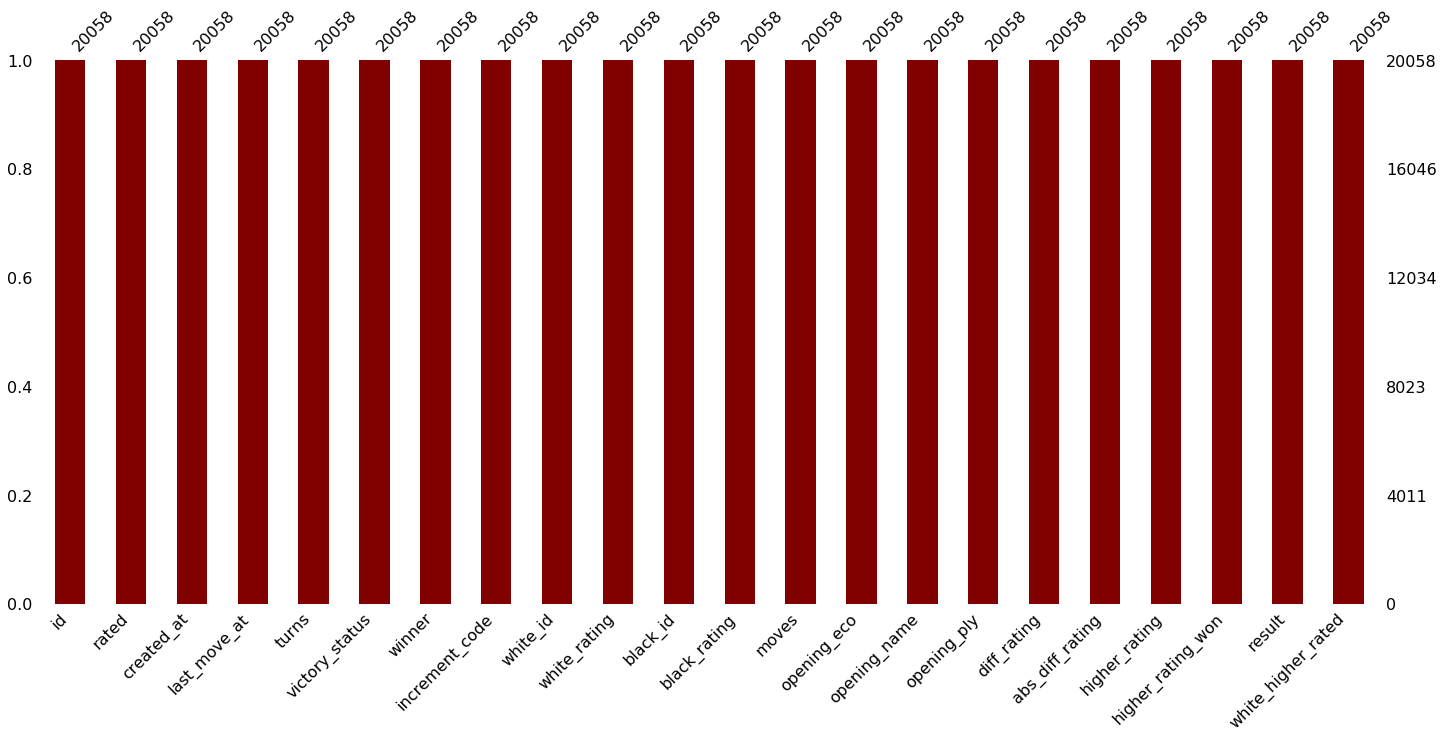

In [14]:
msn.bar(games, color = 'maroon')

This awesome functions gives us a bar plot of the number of complete values in each variable. Incomplete values get signalled by a bar not reaching the 1.0 roof. Since all bars reach 1.0,  we can easily tell no missing values are in the set. 

## Exploratory Data Analysis

In this section, we examine the variables of interest in our dataset with a statistical magnifying glass. 

In [15]:
import seaborn as sns

In [16]:
sns.set_style("dark")    # Because we're cool

### Absolute value in differences
We'll start by checking out our abs_diff_rating variable. 

In [17]:
games.abs_diff_rating.describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_diff_rating, dtype: float64

A brief look at the read out lets us know most of our variables (the third quantile) had an absolute difference of 241 points. 
The max rating of 1605 smells suspiciously like an outlier. Below, we can see a histogram of this distribution. 

Text(0.5, 0, 'Absolute Value Difference in Rating')

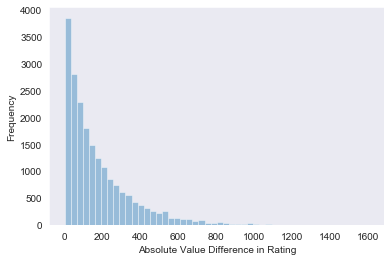

In [18]:
sns.distplot(games.abs_diff_rating,
                        kde=False)
plt.ylabel('Frequency')
plt.xlabel('Absolute Value Difference in Rating')

We can see we've got a one tailed right skewed distribution of absolute values in rating. This also shows graphically how most matches took place between players ratted 200 or less. 

A box plot helps us visualize possible outliers.

Text(0.5, 0, 'Absolute Value Difference in Rating')

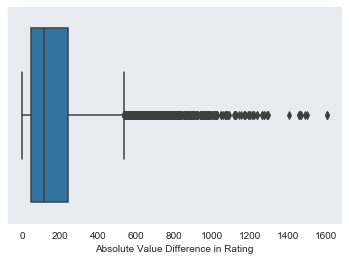

In [19]:
sns.boxplot(x="abs_diff_rating", data=games)
plt.xlabel('Absolute Value Difference in Rating')

It looks like after the 580 absolute value difference, we have a hoard of upper outliers. We need not, however, remove them yet since they could inform how large differences contribute to percentages of winning. Note that we don't have low outliers since all of our values are positive. 

Let's find out how many of these upper outliers we have.

In [20]:
# We use the boxplot definition of outliers inline with our plot above.
quartiles = np.percentile(games.abs_diff_rating, [25, 50, 75])
upper_cutoff = games.abs_diff_rating.mean() + 1.5 * ( quartiles[2] - quartiles[0] ) 

In [21]:
np.round(upper_cutoff)

467.0

Our upper cutoff tells us that any game having an absolute difference greater than 467 can be consider an outlier. 

In [22]:
games.loc[games.abs_diff_rating > upper_cutoff, 'abs_diff_rating']

7        695
11       486
12       555
20       582
26       746
        ... 
19921    771
20012    768
20041    507
20042    494
20053    471
Name: abs_diff_rating, Length: 1491, dtype: int64

So, we have 1461 outliers.

I'm curious. Do these big differences in rating have a high proportion of wins for the higher rated player? 

In [23]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts()

1    1257
0     234
Name: higher_rating_won, dtype: int64

Recall that a value of 1 means the higher rated player won, 0 if they drew or lost. Thus, we can interpret this as saying that in these outlier games, 1257 matches resulted in a win for the higher rated player, while 234 of those matches resulted in a loss. As a proportion, we have:

In [24]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts(1)

1    0.843058
0    0.156942
Name: higher_rating_won, dtype: float64

Deciding to keep the outliers depends on the kind of model we use. So, for the moment, we will leave the outliers in the dataset.

### Victory status
We will now take a look at the frequency for victory status. 

Text(0.5, 0, 'Victory Statues')

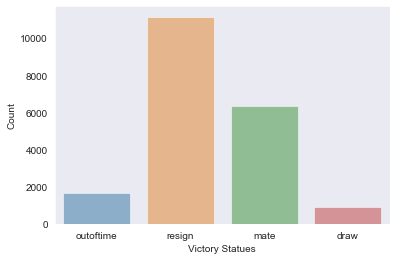

In [25]:
sns.countplot(x = 'victory_status', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Victory Statues')

Most players resigned before being submitted to the shame of a mate. Note how very little draws there are proportionate to the other results. 

When I've played online, I've sometimes beat a better player by having them run out of time. I wonder what we can say about the proportion of wins by a lower rated player due to running out of time. 

In [26]:
victory_group = games.victory_status.groupby(games.higher_rating_won)

In [27]:
victory_group.value_counts(1)

higher_rating_won  victory_status
0                  resign            0.516091
                   mate              0.276668
                   draw              0.117571
                   outoftime         0.089670
1                  resign            0.580473
                   mate              0.339459
                   outoftime         0.080068
Name: victory_status, dtype: float64

The first number (0 or 1) lets us know if the higher rating won. If we look at 0 - the higher rating lost, the outoftime percentage is 0.08967. This is only slightly higher for when the higher rating won at 0.080068. 

### Higher Rating Won

We are interested in checking out how often the higher rating won since this will be one of our response variables in our predictions. 

Text(0.5, 0, 'Higher Rating Won')

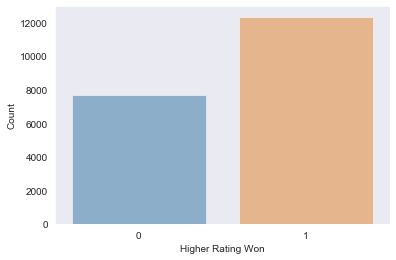

In [28]:
sns.countplot(x = 'higher_rating_won', data = games,  alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Higher Rating Won')

Below is a specific numerical proportion.

In [29]:
games.higher_rating_won.value_counts(1)

1    0.615814
0    0.384186
Name: higher_rating_won, dtype: float64

So 61% of the time, the higher rating won. 

### Number of turns

We also check out the distribution for the number of turns taken. 

Text(0.5, 0, 'Turns')

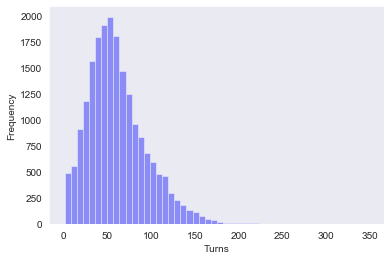

In [30]:
sns.distplot(games.turns, kde = False, color = 'b')
plt.ylabel('Frequency')
plt.xlabel('Turns')

Looks like most turns hover around 50. A numerical distribution is shown below.

In [31]:
games.turns.describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

We get a mean and a median that are similar at 60.46 (so 60 turns) and 55 respectively. Seeing 349 for a max number of turns makes me curious. What more can I say about that match?

In [32]:
games.iloc[games.turns.max()]

id                                                             2icRDIZI
rated                                                              True
created_at                                                  1.50394e+12
last_move_at                                                1.50394e+12
turns                                                               120
victory_status                                                     mate
winner                                                            black
increment_code                                                     10+0
white_id                                                       bomardan
white_rating                                                       1589
black_id                                                          tfeng
black_rating                                                       1569
moves                 d4 Nf6 c4 g6 Nc3 d5 Nf3 Bg7 Bf4 O-O Nb5 c6 Nc7...
opening_eco                                                     

The players had similar ratings of 1589 (white) and 1569 (black), although black ended up winning via mate. 

Don't know if you saw this, but we had a minimum of 1 for turns (look out our output for numerical description of turn data). This is alarming since such games would probably not provide useful information in our models. 

We need to come up with a cut off for how many turns is acceptable in our set. In chess, the fastest check mate is called the Fool's Mate and can happen in two turns. So a cut off of two turns might be acceptable for a realistic match. This, however, happens rarely, so we will instead be conservative and place 10 arbitrarily as our threshold. Since most of our games  were around 55 to 60 moves, (mode of 55 and mean of 60) removing games with less than 10 turns would be helpful. Firstly, because there would probably be very few matches that were truly lost in 10 moves, and secondly, because many games that were not reasonable in nature (e.g. a player resigns because they need to go to the restroom) get removed. 

So, let's remove games with less than 10 turns from our data. 

In [33]:
games.drop(games[games.turns < 10].index, inplace = True)

### Result 

Let's look at the result variable. Recall that this variable encodes whether the higher rated player lost (0), drew (1), or won (2). 

Text(0.5, 0, 'Result')

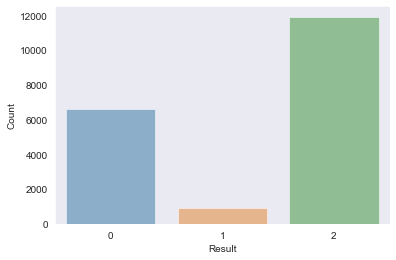

In [34]:
sns.countplot(x = 'result', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Result')

This reflects our victory status variable. For the higher rated player, we have mostly wins (2), a little more than half of these are losses (0), and a small proportion turn out to be draws (1). We can see numerical proportions below.

In [35]:
games.result.value_counts(1)

2    0.612829
0    0.340157
1    0.047014
Name: result, dtype: float64

The higher rated player won 61% of the time, lost 34% of the time, and drew about 5% of the time.

### Increment code 
You have noticed a variable called increment code. 

In [36]:
games.increment_code

0         15+2
1         5+10
2         5+10
3         20+0
4         30+3
         ...  
20053    10+10
20054     10+0
20055     10+0
20056     10+0
20057     10+0
Name: increment_code, Length: 19441, dtype: object

This variable gives us how much each player will receive in rating increase after a match is finished. Intuitively, if a high rated player beats a lower rated player, the higher rated player would receive a few points. But, if the lower rated player beat the higher rated player, they would probably receive a higher amount of points. A draw could result in players receiving the same increment. 

I sound like an expert in this variable, but I'm not. It's my guess. Let's see if my guess holds. To do so, we will check drawed games and see if the increment is equal. 

In [37]:
games.loc[games.victory_status == 'draw', 'increment_code']

40       20+25
98        15+0
126      15+15
143      15+15
181       15+5
         ...  
20003    30+30
20004    30+30
20011    45+45
20014    45+45
20034    45+45
Name: increment_code, Length: 870, dtype: object

So the increment isn't always equal. But this makes sense since a lower rated player could draw with a higher rated player and deserve to be elevated. 

A potential rabbit hole for us to jump is figuring out how an increment code is determined based on result and difference in rating. But we'll leave that for another bedtime story. 

### Exploratory Data Analysis Summary

1) We need not worry about low outliers in the absolute value of differences between ratings. High outliers, however, do exist (according to our definition of boxplot outliers), and we will deal with them based on the models we apply to the data. 

2) For the higher rated player, most of the games end up as wins ~61%, then losses ~34% with a majority of resignations, instead of checkmates. A small percentage of the matches are draws ~5%. 

3) The turns variable revealed short turn games, and we removed any matches that had less than 10 turns. 

4) An interesting study would be to determine how increment codes are decided. 

Since we removed turns outliers from the data, we will re-write out the dataset for later use. 

In [45]:
games.to_csv('games_new_vars.csv')

## Getting the plan straight

After going through the grand experience of the EDA, you may have forgotten what kind of modelling wonders we're trying to do. So here's the dealio again. 

We imagine we're sitting down to play a chess match. Since we're both pretty bad ass, we've already racked up some kind of rating. We'll say you've been practicing more so you're now touting that higher rating. What's the chance that you'll end up winning? What if you're playing as white instead of black? What if the game has been going on for like a bajillion moves now?

Using Python's groovy machine learning libraries, we'll answer these dire questions. 

We'll get cracking on predicting wins and losses (binary case) for the higher rated player first. 

## Cooking up binary models

#### Normalization, response setting, and other params

Before fitting models, we will normalize our data. This matters because we intend on using multiple predictors, and our predictors could be on different scales. We'll knight these predictors with a big 'X' for a name. 

In [47]:
from sklearn.preprocessing import normalize
X = normalize(games[ [ 'abs_diff_rating', 'turns', 'white_higher_rated' ] ])

In [51]:
games = pd.read_csv('games_new_vars.csv')

We set up a response and give it a wildly descriptive 'y'. 

In [52]:
y = games[ 'higher_rating_won' ]

Some of the algorithms below automatically randomize. So, if we're not careful, we could end up always getting different numbers for the model results. By setting a RANDOM STATE, we can pick a result and stick with throughout the analysis. Also, when we cross validate using K fold cross validation we will specify 10 folds through NUMBER FOLDS. 

In [53]:
RANDOM_STATE = 1
NUMBER_FOLDS = 10

#### Logistic regression

We will begin with a Logistic Regression and perform a stratifed 10 fold cross validation on the model. 

In [54]:
lg_confusion_matrix = cu.run_logistic_regression(NUMBER_FOLDS, X, y, RANDOM_STATE)
lg_results = cu.get_cm_results(lg_confusion_matrix)

#### Tree based methods

Next up, we fit a bag of trees to our data. In the case of fitting a bag of trees and a random forest, we will use 100 estimators. This means that we will be using 100 trees in each case to build the models. 

In [55]:
NUMBER_ESTIMATORS = 100

In [56]:
bag_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
bag_results = cu.get_cm_results(bag_confusion_matrix)

In [57]:
r_forest_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
r_forest_results = cu.get_cm_results(r_forest_confusion_matrix)

#### Results readings

How did our beautiful models do? We can plot a confusion matrix for each model and gaze in wonder. 

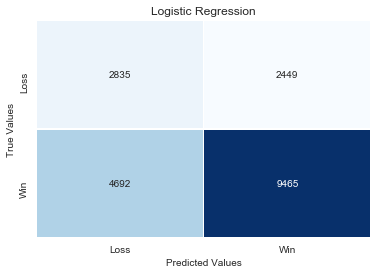

In [58]:
cu.create_cm_plot( 'Logistic Regression', lg_confusion_matrix )

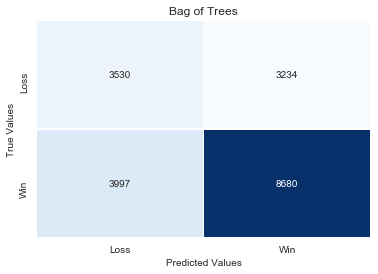

In [59]:
cu.create_cm_plot( 'Bag of Trees', bag_confusion_matrix )

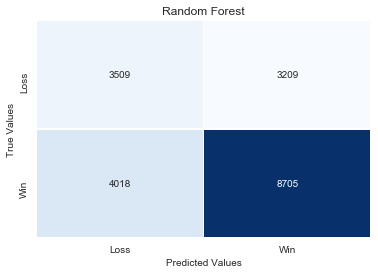

In [60]:
cu.create_cm_plot( 'Random Forest', r_forest_confusion_matrix )

In case you're rusty on the magic of confusion matrices, recall that confusion matrices help us determine how well the model performed by comparing our guesses to the truth and nothing but the truth. After admiring the excellent shades of blue, you will probably notice the bottom right hand square in the matrices above. This square denotes an accuracte prediction for wins, and it looks like the models do very well when predicting wins. 

A whole tribe of metrics based on a confusion matrix exist. We'll acquire these then plot these to determine more specific model performance.

In [61]:
accuracy, precision, recall, fmeasure, specificity, negative_pv = cu.group_important_results(lg_results, bag_results, r_forest_results)

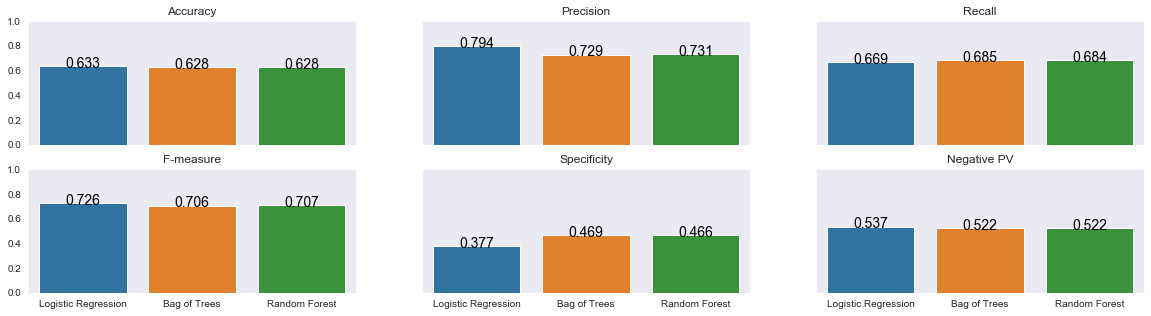

In [62]:
cu.create_specific_results_plot(r_forest_results, lg_results, bag_results, 3, 2) # 3 cols, 2 rows

We've got six different metrics to chew on here so put on your seat belt. 

- First, is accuracy. This is a general metric. It tells us how often the model correctly predicts the value. It's not hard to see that all models seem to hover at around 62% of accuracy. In other words, the model makes a good prediction (good boy!) 62% of the time. 

- Second, is precision. This tells us how often the model predics a win. Here, the Logistic Regression pulls ahead at 0.794 and says cheers to the other two models.  

- Third, is recall. This tells us how accurately we predicted the wins. Our models seem to hover at around 68%. 

- Fourth, is the famous fabulous fmeasure. This combines precision and recall into one spiffy measurement. In our case, it looks like most models however around 70%. 

- Fifth, is specificity. The specifics on specificity are simple. The measure let's us know stuff about losses. In particular, out of the times we predicted a loss how often were we right? And, goodness gracious the Logistic Regression just sags here at only 37% compared to the others at around 46%. 

- Finally, we got negative pv. This is short for negative predictive value, and this tells us what percentage of true losses our models caught. Most of the models do equally pitifully at around 52%.  

##### Conclusion
So what can we say? These models perform similarly across most measurements. The models do splendidly when they predict wins (Logistic Regression in particular), but they trip awkwardly when predicting losses (Logistic Regression in particular). 

We could also compare with the null rate. This measures the accuracy if we just predicted every response to the dominant class. Using different word words, this is the accuracy of a model that simply predicts a win no matter what. 

In [63]:
null_rate = np.abs( (y - 1 ).sum() ) / len( games )
null_rate

0.3871714417982614

And it is cute, and encouragingly, worse than the accuracy of any of our models above. 

For those pursuing extra credit, we also show plots for each model packaged with its confusion matrix measurements.

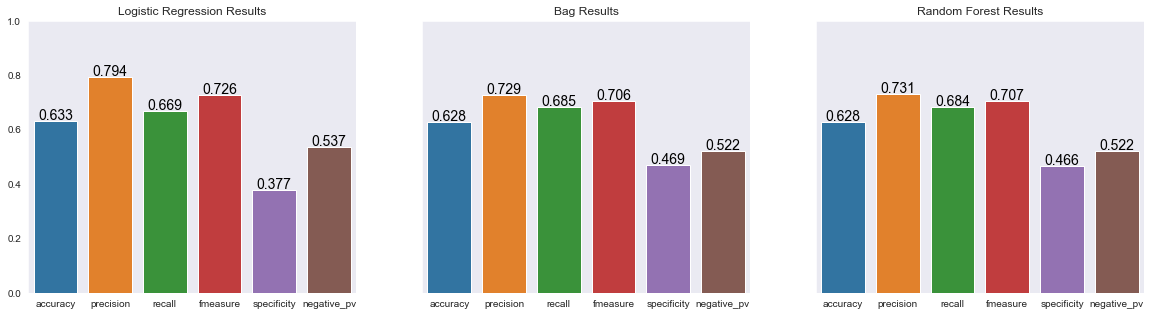

In [64]:
cu.create_cumulative_results_plot(r_forest_results, lg_results, bag_results)

They look like they all pretty similar. 

## Beyond binary 

In this section, we go to town. We refit our tree based models with our response will as 'result'. Recall this encoded whether games were a loss, draw, or win for the higher rated player. We eschew trying a three class classification with a logistic regression 'cuz it isn't a popular choice. 

In [65]:
y = games['result']

#### Bag those Trees

We kick it off again a bag of trees. Here, we also run stratified 10 fold cross validation.  

In [66]:
bag_multi_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We also fit the random forest in exactly the same way. 

In [67]:
r_forest_multi_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We can start by comparing the accuracy of our two models. 

In [68]:
r_forest_accuracy = cu.get_accuracy_three_class( r_forest_multi_confusion_matrix )
bag_accuracy = cu.get_accuracy_three_class( bag_multi_confusion_matrix )
accuracies = {'Random Forest': r_forest_accuracy, 'Bag of Trees': bag_accuracy}

(0, 1)

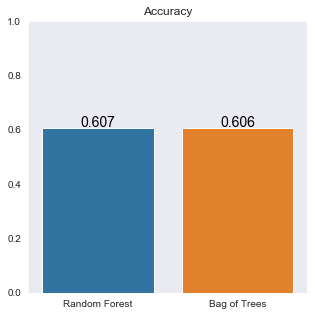

In [69]:
fig, axs = plt.subplots(figsize=[5, 5], gridspec_kw={'wspace': 0.2})
cu.create_bar_results(accuracies, 'Accuracy', axs)
plt.ylim([0, 1])

Our hearts say 'bummer'. They classify correctly about 60% of the time. We, however, don't immediately lose hope since maybe more specific metrics will uplift us. 

In a three class confusion matrix, we usually consider precision and recall for each class. So, we'll join the herd and do so as well. 

##### Loss

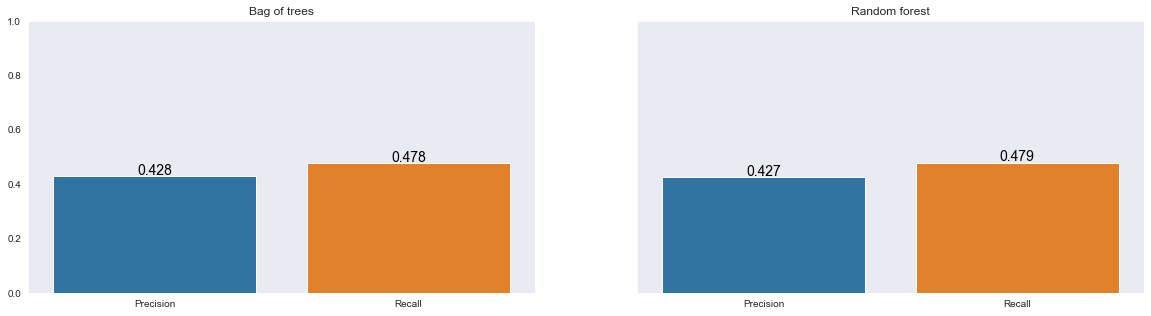

In [70]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 0 )    # 0 for loss

Uncannily, the precision and recall is quite similar for the bag and forest. This considers the losses predicted by the model. So, when we predict a lost, we are right around 43% of the time (precision). But out of all the losses we should've predicted, we only got 48% (recall). 

##### Draw

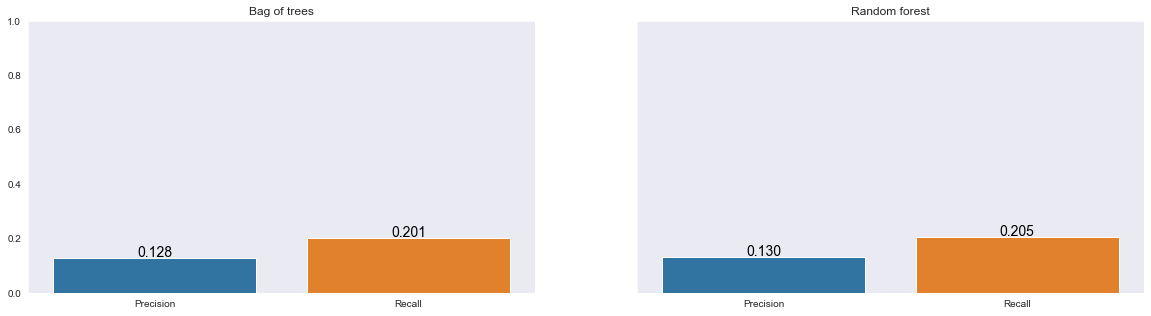

In [71]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 1 )    # 1 for draw

Egad. Our models sink to new lows when trying to predict a draw between the two players. When we predict a draw, we are right about 13% of the time (precision). Also, out of all the draws we should've predicted, we only got 20% (recall). 

##### Winning

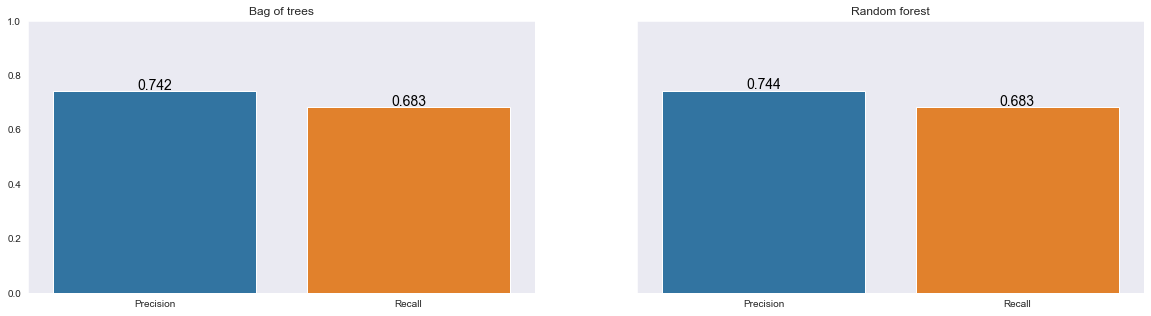

In [72]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 2 )    # 2 for win

Applauds wildly. Our models rise to new heights when predicting wins. When we predict a win, we are right around 74% of the time (precision). But out of all the wins we should've predicted, we only properly predicted 68% (recall). 

##### Conclusion

So, we can say our model wins at predicting wins, loses at predicting losses, and jumps off a cliff when trying to predict draws. 

## Looking back fondly

This wraps up our analysis. Although the models do well when predicting wins, further work will need to be done if we want them to win at predicting losses and draws. Also note how the bar graphs gave off orange and blue, just like my alma mater completely by accident. Or was it an accident?

## Now what

A recent one person survey said that 100% of me was thankful for your taking the time to peruse this document. 

You may be wondering what do now. I suggest watching dance videos on youtube. But say you wanted to see the next episode of this chess analysis, I would probably attempt to better the predictive models by: 

- Using more predictors (like the kinds of openings used). It's possible that other predictors could give more determining info about wins. 

- Getting my hands on more observations. This data set carried almost 20 000 records. What if tried this with 200 000 or 1 000 000 000 records. That would be cool.   

- Trying new models. There's a whole zoo of models out there, and we only visited the logistic regression and trees. Perhaps an additive GLM. Or a neural network. 

- It's possible that the models do poorly with losses and draws because not many losses and draws are present in the data. Perhaps bootstrapping loss and draw data would help the models. (I'm just freestyling here). 

## Cheers

I'm currently my own agent so if you liked this drop me a line and let me know whassup. Wishing you a splendid day.